In [1]:
import pandas as pd
import seaborn as sns
import re
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 160)
pd.set_option('display.max_columns', 80)
pd.set_option('display.max_colwidth', 500)

## Setup
setting up options for dataset, which affects data used or ML method

In [3]:
#loading data from file
df = pd.read_parquet(path='datasets/euro_processed_full_data.gzip') # full dataset
# df = pd.read_parquet(path='datasets/euro_processed_data.gzip') # smaller dataset in selected price range

In [4]:
drop_outliers = True # drop 3% of the most expensive products, that have the rarest components included
drop_interfaces = False # drop data about interfaces - that simplifies a model
correlation_threshold = 0.1 # limit numerical columns with small correlation coeficient 

In [5]:
df = df.set_index(keys=df['Kod producenta']).drop(columns=['Kod producenta'])

### Option to extend
add column that specifies Apple products - these elements have different approach to some data, so it might become unclear when data do not distinguish this manufacturer

## Conclusions
analysis of data and initial results of model gives possibility to adjust features or remove ones that might not provide either relevant or high quality data. Data to be modified at this step:  
**Cat_SSD_type** - data are ambigous - at some point disc type is provided, at others - communication protocol of that disc  
**Cat_Cale** - convertion back to category (for some reason Parquet file did not maintain category information of integer data)  
**Cat_Typ** - no clear explanation for this classification. This value might be biased.

In [6]:
df.drop(columns=['Cat_SSD_type','Cat_Typ', 'Cat_Dystrybutor'], inplace=True)

In [7]:
df['Cat_Cale'] = df['Cat_Cale'].astype('string')
df['Cat_Brand'] = df['Cat_Brand'].astype('category')

In [8]:
if drop_outliers:
    threshold_min = df['Cena'].quantile(q=0.03, interpolation='nearest')
    threshold_max = df['Cena'].quantile(q=0.97, interpolation='nearest')
    df = df[df['Cena']>threshold_min]
    df = df[df['Cena']<threshold_max]
    print(f'Products with the price higher than {threshold_max} and lower than {threshold_min} were removed from dataset.')

Products with the price higher than 15799.0 and lower than 1749.0 were removed from dataset.


In [9]:
corr_matrix =df.select_dtypes(['number', 'bool']).corr()
low_correlation_columns = list(corr_matrix[abs(corr_matrix['Cena'])< correlation_threshold].index)
if len(low_correlation_columns)> 0:
    df.drop(columns = low_correlation_columns, inplace=True)
print(f'Columns to be removed due to correlation absolute value lower than {correlation_threshold}:')
print(*low_correlation_columns, sep='\n')

Columns to be removed due to correlation absolute value lower than 0.1:
Bin_Czytnik kart
Bin_Mikrofon
Int_sloty RAM
IF_LAN
IF_USB 3.2
IF_USB 3.1 Typ C (z Thunderbolt)
IF_HDMI 2.0
IF_USB 3.2 Typ C (z DisplayPort/Power Delivery)
IF_VGA
IF_USB 3.1 Typ C (z DisplayPort)
IF_wejście mikrofonowe
IF_USB 3.1 Typ C (z DisplayPort/Power Delivery)
IF_USB 3.2 Typ C (z Thunderbolt)
IF_DisplayPort
IF_USB 3.1 Gen 2 Typ C
IF_USB 3.2 Typ C (z DisplayPort)
IF_USB 4 Typ C (z DisplayPort)
IF_wejście liniowe audio


In [10]:
if drop_interfaces:
    interfaces =[column for column in df.columns if column.startswith("IF_")]
    df.drop(columns=interfaces, inplace=True)
    print(f'{len (interfaces)} columns with interfaces data was removed. List of removed columns:')
    print(*interfaces, sep='\n')

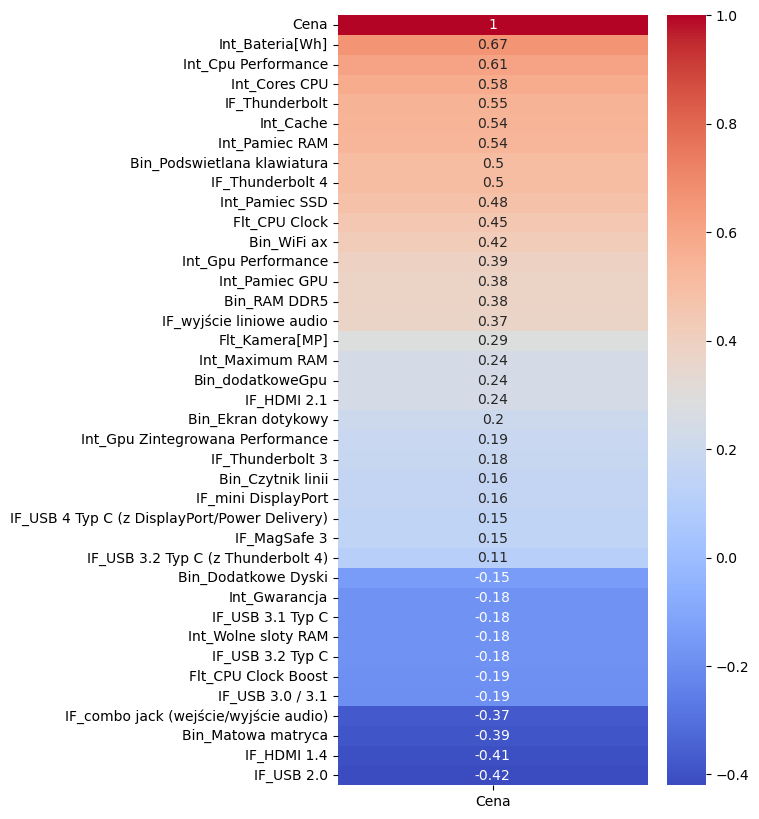

In [11]:
corr_matrix =df.select_dtypes(['number', 'bool']).corr()
plt.figure(figsize=(5,10))
sns.heatmap(corr_matrix[['Cena']].sort_values(by='Cena',ascending=False), cmap='coolwarm', annot=True)
plt.show()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1094 entries, 5515-8154 to 82JU00JHPB.W
Data columns (total 54 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Nazwa                                          1094 non-null   object  
 1   Cena                                           1094 non-null   float64 
 2   Link                                           1094 non-null   object  
 3   Model procesora                                1094 non-null   object  
 4   Cat_Brand                                      1094 non-null   category
 5   Cat_Gwarancja                                  1094 non-null   category
 6   Cat_LAN                                        1094 non-null   category
 7   Cat_Rodzaj matrycy                             1094 non-null   category
 8   Cat_OS                                         1094 non-null   category
 9   Cat_Obudowa                   

In [13]:
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.compose import ColumnTransformer
from lightgbm import LGBMRegressor

In [14]:
from sklearn import __version__
__version__

'1.4.1.post1'

In [15]:
df_cleaned = df.dropna()
len(df_cleaned)

1094

In [16]:
X = df_cleaned.select_dtypes(exclude=['object']).drop(columns=['Cena'])
y = df_cleaned['Cena']

categories = X.select_dtypes(include=['category']).columns
numericals =[column for column in df.columns if column.startswith("Int_")]
floats =[column for column in df.columns if column.startswith("Flt_")]
binaries =[column for column in df.columns if column.startswith("Bin_")]

numericals.extend(floats)

In [17]:
categories

Index(['Cat_Brand', 'Cat_Gwarancja', 'Cat_LAN', 'Cat_Rodzaj matrycy', 'Cat_OS',
       'Cat_Obudowa', 'Cat_Częstotliwość', 'Cat_Rozdzielczość'],
      dtype='object')

In [18]:
threshold = 0.01#assumed that important categories have more than 2% of share in the dataset
other_category = "Other"
print("Category columns to simplify:")
for category in X[categories]:
    relevant_categories = list(X[category].value_counts()[X[category].value_counts() >threshold*len(X)].index)
    if len(relevant_categories) + 1 >= X[category].nunique():
        continue
    print(category)
    relevant_categories.append(other_category)
    X[category] = X[category].cat.set_categories(relevant_categories)
    X[category] = X[category].fillna(other_category)

Category columns to simplify:
Cat_Brand
Cat_Rodzaj matrycy
Cat_OS
Cat_Częstotliwość
Cat_Rozdzielczość


In [19]:
summ= pd.DataFrame()
summary = {}
for c in X[categories]:
    summary['Name'] = c
    summary['Simpified categories count'] = X[c].nunique()
    summary['Original categories count'] = df[c].nunique()
    data_row = pd.DataFrame.from_records(data=[summary])

    summ = pd.concat([summ, data_row])
    
summ.reset_index(inplace= True)
summ.drop(columns='index', inplace= True)
summ

,Name,Simpified categories count,Original categories count
0,Cat_Brand,11,16
1,Cat_Gwarancja,2,2
2,Cat_LAN,4,4
3,Cat_Rodzaj matrycy,9,12
4,Cat_OS,9,14
5,Cat_Obudowa,4,4
6,Cat_Częstotliwość,7,8
7,Cat_Rozdzielczość,10,30


In [20]:
degree = 2
preprocessor = ColumnTransformer(
    transformers=[
        ('oh', OneHotEncoder(), categories),
        ('n', MinMaxScaler(), numericals),
        ('b','passthrough', binaries)
    ]   
)

In [21]:
model = LGBMRegressor()
X_scaled = pd.DataFrame(preprocessor.fit_transform(X), index=X.index, columns=preprocessor.get_feature_names_out(X.columns))

In [22]:
X_scaled = X_scaled.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)

In [24]:
model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000547 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 353
[LightGBM] [Info] Number of data points in the train set: 732, number of used features: 58
[LightGBM] [Info] Start training from score 5379.113388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

LGBMRegressor()

In [25]:
y_pred = model.predict(X_test)

In [26]:
dict(zip(X_scaled.columns,model.feature_importances_))

{'oh__Cat_Brand_ASUS': 15,
 'oh__Cat_Brand_Acer': 25,
 'oh__Cat_Brand_Apple': 18,
 'oh__Cat_Brand_Dell': 21,
 'oh__Cat_Brand_HP': 7,
 'oh__Cat_Brand_Huawei': 0,
 'oh__Cat_Brand_LG': 0,
 'oh__Cat_Brand_Lenovo': 42,
 'oh__Cat_Brand_MSI': 0,
 'oh__Cat_Brand_Microsoft': 0,
 'oh__Cat_Brand_Other': 0,
 'oh__Cat_Gwarancja_premium': 36,
 'oh__Cat_Gwarancja_standardowa': 0,
 'oh__Cat_LAN_100Mbps': 0,
 'oh__Cat_LAN_1000Mbps': 41,
 'oh__Cat_LAN_2500Mbps': 0,
 'oh__Cat_LAN_NA': 12,
 'oh__Cat_Rodzajmatrycy_IPS': 53,
 'oh__Cat_Rodzajmatrycy_LED': 4,
 'oh__Cat_Rodzajmatrycy_LiquidRetina': 0,
 'oh__Cat_Rodzajmatrycy_LiquidRetinaXDR': 0,
 'oh__Cat_Rodzajmatrycy_OLED': 7,
 'oh__Cat_Rodzajmatrycy_Other': 0,
 'oh__Cat_Rodzajmatrycy_Retina': 0,
 'oh__Cat_Rodzajmatrycy_TN': 5,
 'oh__Cat_Rodzajmatrycy_WVA': 5,
 'oh__Cat_OS_Other': 0,
 'oh__Cat_OS_Windows10HomeEdition': 12,
 'oh__Cat_OS_Windows10Professional': 0,
 'oh__Cat_OS_Windows11HomeEdition': 62,
 'oh__Cat_OS_Windows11Professional': 19,
 'oh__Cat_OS_bez

In [27]:
# Predykcja na danych testowych
output_df = X_test
output_df['Predicted Price'] = model.predict(X_test)
output_df['Real Price'] = y_test
output_df['Predicted Gain'] = output_df['Predicted Price'] - output_df['Real Price']
output_df['Predicted Gain[%]'] = output_df['Predicted Gain'] / output_df['Real Price'] * 100


In [28]:
# Ocena modelu
mse = root_mean_squared_error(y_pred, y_test)
print(f'Root Mean Squared Error: {int(mse)}')
print(f'Root Mean Squared Error per product: {int(mse/ len(y_pred))}')


Root Mean Squared Error: 941
Root Mean Squared Error per product: 2


In [29]:
len(output_df)

362

In [30]:
output_df.iloc[:,:].sort_values(by='Predicted Gain[%]').tail(10)

,oh__Cat_Brand_ASUS,oh__Cat_Brand_Acer,oh__Cat_Brand_Apple,oh__Cat_Brand_Dell,oh__Cat_Brand_HP,oh__Cat_Brand_Huawei,oh__Cat_Brand_LG,oh__Cat_Brand_Lenovo,oh__Cat_Brand_MSI,oh__Cat_Brand_Microsoft,oh__Cat_Brand_Other,oh__Cat_Gwarancja_premium,oh__Cat_Gwarancja_standardowa,oh__Cat_LAN_100Mbps,oh__Cat_LAN_1000Mbps,oh__Cat_LAN_2500Mbps,oh__Cat_LAN_NA,oh__Cat_Rodzajmatrycy_IPS,oh__Cat_Rodzajmatrycy_LED,oh__Cat_Rodzajmatrycy_LiquidRetina,oh__Cat_Rodzajmatrycy_LiquidRetinaXDR,oh__Cat_Rodzajmatrycy_OLED,oh__Cat_Rodzajmatrycy_Other,oh__Cat_Rodzajmatrycy_Retina,oh__Cat_Rodzajmatrycy_TN,oh__Cat_Rodzajmatrycy_WVA,oh__Cat_OS_Other,oh__Cat_OS_Windows10HomeEdition,oh__Cat_OS_Windows10Professional,oh__Cat_OS_Windows11HomeEdition,oh__Cat_OS_Windows11Professional,oh__Cat_OS_bezsystemu,oh__Cat_OS_macOSBigSurlubnowszy,oh__Cat_OS_macOSMontereylubnowszy,oh__Cat_OS_macOSVenturalubnowszy,oh__Cat_Obudowa_,oh__Cat_Obudowa_composite,oh__Cat_Obudowa_metal,oh__Cat_Obudowa_plastic,oh__Cat_Czstotliwo_120Hz,...,oh__Cat_Czstotliwo_60Hz,oh__Cat_Czstotliwo_90Hz,oh__Cat_Czstotliwo_Other,oh__Cat_Rozdzielczo_1920x1080pikseli,oh__Cat_Rozdzielczo_1920x1200pikseli,oh__Cat_Rozdzielczo_2240x1400pikseli,oh__Cat_Rozdzielczo_2560x1440pikseli,oh__Cat_Rozdzielczo_2560x1600pikseli,oh__Cat_Rozdzielczo_2560x1664pikseli,oh__Cat_Rozdzielczo_2880x1800pikseli,oh__Cat_Rozdzielczo_2880x1864pikseli,oh__Cat_Rozdzielczo_3024x1964pikseli,oh__Cat_Rozdzielczo_Other,n__Int_PamiecGPU,n__Int_Gwarancja,n__Int_CoresCPU,n__Int_PamiecRAM,n__Int_BateriaWh,n__Int_Cache,n__Int_PamiecSSD,n__Int_MaximumRAM,n__Int_WolneslotyRAM,n__Int_CpuPerformance,n__Int_GpuPerformance,n__Int_GpuZintegrowanaPerformance,n__Flt_KameraMP,n__Flt_CPUClock,n__Flt_CPUClockBoost,b__Bin_DodatkoweDyski,b__Bin_Podswietlanaklawiatura,b__Bin_Czytniklinii,b__Bin_Ekrandotykowy,b__Bin_RAMDDR5,b__Bin_Matowamatryca,b__Bin_WiFiax,b__Bin_dodatkoweGpu,Predicted Price,Real Price,Predicted Gain,Predicted Gain[%]
Kod producenta,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
NX.A84EP.00G,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.181818,0.428571,0.277778,0.081967,0.225806,0.130435,0.0,0.199553,0.000000,0.000000,0.092,0.297297,0.513514,1.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,3115.289074,2149.0,966.289074,44.964592
NX.KNUEP.008,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.363636,0.142857,0.347222,0.147541,0.225806,0.043478,0.0,0.208247,0.100902,1.000000,0.200,0.621622,0.297297,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,3841.394297,2499.0,1342.394297,53.717259
X1502ZA-BQ438W,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.454545,0.428571,0.194444,0.147541,0.225806,0.130435,0.0,0.279128,0.100902,1.000000,0.100,0.621622,0.297297,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,4343.108590,2799.0,1544.108590,55.166438
82H900GHPB,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.5,0.000000,0.142857,0.138889,0.049180,0.225806,0.086957,0.0,0.067225,0.055211,0.547170,0.090,0.540541,0.297297,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3053.691275,1899.0,1154.691275,60.805228
GA503-LN126WA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.272727,1.000000,0.861111,0.213115,0.483871,0.478261,0.0

In [31]:
# jump to selected product page
# output_df.loc[['8V6-00003 KCM-00031 QQ2-01434', '']]

<Axes: >

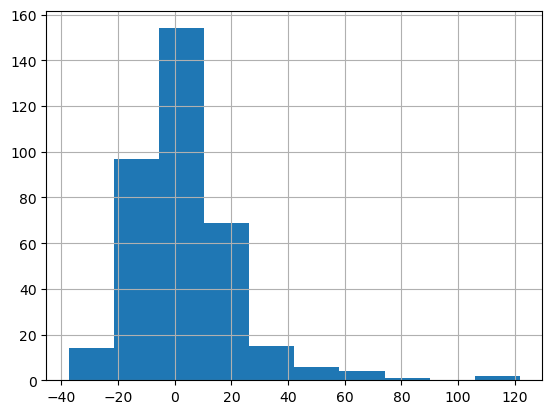

In [32]:
output_df['Predicted Gain[%]'].hist()

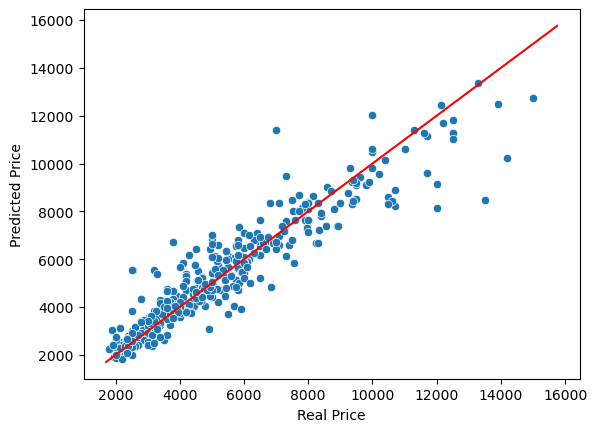

In [33]:
min_point = 0.95 * output_df['Real Price'].min()
max_point = 1.05* output_df['Real Price'].max()
sns.scatterplot(data = output_df, x='Real Price', y='Predicted Price')
plt.plot([min_point, max_point],[min_point, max_point], c='r')
plt.show()